In [1]:
import math
import matplotlib.pyplot as plt
import torch

from azula.sample import LMSSampler
from einops import rearrange
from functools import partial
from omegaconf import OmegaConf
from pathlib import Path

from lpdm.data import field_preprocess, get_label, get_well_multi_dataset, isotropic_power_spectrum
from lpdm.diffusion import MaskedDenoiser, get_denoiser
from lpdm.nn.autoencoder import get_autoencoder
from lpdm.plot import animate_fields

plt.rcParams["animation.ffmpeg_path"] = "/mnt/sw/nix/store/fz8y69w4c97lcgv1wwk03bd4yh4zank7-ffmpeg-full-6.0-bin/bin/ffmpeg"  # fmt: off
plt.rcParams["animation.html"] = "html5"

_ = torch.manual_seed(0)

/mnt/home/frozet/mpp-ldm/lpdm/nn/attention.py:9: FutureWarning: xformers.components is deprecated and is not maintained anymore. It might be removed in a future version of xFormers 
  import xformers.components.attention.core as xfa


In [2]:
# runpath = Path("/mnt/ceph/users/frozet/mpp-ldm/runs/eu2uo1e9_dit_large_soap_3e-05_0.0_cosine_1")  # fmt: off
runpath = Path("/mnt/ceph/users/frozet/mpp-ldm/runs/ki01263m_dit_large_soap_3e-05_0.0_cosine_1")  # fmt: off
cfg = OmegaConf.load(runpath / "config.yaml")
cfg.ae = OmegaConf.load(runpath / "autoencoder/config.yaml")
device = "cuda"

## Data

In [3]:
rollout_length = 64 // cfg.trajectory.stride + 1

testset = get_well_multi_dataset(
    path="/mnt/ceph/users/polymathic/the_well/datasets",
    physics=cfg.dataset.physics,
    split="test",
    steps=rollout_length,
    min_dt_stride=cfg.trajectory.stride,
    max_dt_stride=cfg.trajectory.stride,
    include_filters=cfg.dataset.include_filters,
)

preprocess = partial(
    field_preprocess,
    mean=torch.as_tensor(cfg.dataset.stats.mean, device=device),
    std=torch.as_tensor(cfg.dataset.stats.std, device=device),
    transform=cfg.dataset.transform,
)

In [4]:
item = testset[666]

x = item["input_fields"]
x = preprocess(x)
x = rearrange(x, "L H W C -> C L H W")

label = get_label(item)

## Autoencoder

In [5]:
autoencoder = get_autoencoder(
    pix_channels=testset.metadata.n_fields,
    **cfg.ae.ae,
)

state = torch.load(runpath / "autoencoder/state.pth", weights_only=True)

autoencoder.load_state_dict(state)
autoencoder.cuda()
autoencoder.eval()

AutoEncoder(
  (encoder): Encoder(
    (descent): ModuleList(
      (0): ModuleList(
        (0): Conv2d(5, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ResBlock(
          (attn): Identity()
          (block): Sequential(
            (0): LayerNorm(dim=-3)
            (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (2): SiLU()
            (3): Identity()
            (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
        )
      )
      (1): ModuleList(
        (0): Sequential(
          (0): Patchify()
          (1): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (1-2): 2 x ResBlock(
          (attn): Identity()
          (block): Sequential(
            (0): LayerNorm(dim=-3)
            (1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (2): SiLU()
            (3): Identity()
            (4): Conv2d(128, 128, kernel_si

In [6]:
x = x.to(device)

with torch.no_grad():
    temp = rearrange(x, "C L H W -> L C H W")
    temp = autoencoder.encode(temp)
    z = rearrange(temp, "L C H W -> C L H W")

## Denoiser

In [7]:
shape = (z.shape[0], cfg.trajectory.length, *z.shape[2:])

denoiser = get_denoiser(
    shape=shape,
    label_features=label.numel(),
    masked=True,
    **cfg.denoiser,
)

denoiser.load_state_dict(torch.load(runpath / "state.pth", weights_only=True))
denoiser.cuda()
denoiser.eval()

PreconditionedDenoiser(
  (backbone): FlattenWrapper(
    (wrappee): EmbeddingWrapper(
      (backbone): DiT(
        (patch): Rearrange('... C (L l) (H h) (W w) -> ... L H W (C l h w)', l=1, h=1, w=1)
        (unpatch): Rearrange('... L H W (C l h w) -> ... C (L l) (H h) (W w)', l=1, h=1, w=1)
        (in_proj): Linear(in_features=128, out_features=1024, bias=True)
        (out_proj): Linear(in_features=1024, out_features=64, bias=True)
        (positional_embedding): Sequential(
          (0): Linear(in_features=3, out_features=1024, bias=True)
          (1): SiLU()
          (2): Linear(in_features=1024, out_features=1024, bias=True)
        )
        (blocks): ModuleList(
          (0-15): 16 x DiTBlock(
            (norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=False)
            (ada_zero): Sequential(
              (0): Linear(in_features=256, out_features=1024, bias=True)
              (1): SiLU()
              (2): Linear(in_features=1024, out_features=6144, bias=Tru

In [8]:
sum(p.numel() for p in denoiser.parameters())

307740480

## Generation

In [9]:
sampler = LMSSampler(denoiser, steps=64).to(device)

mask = torch.zeros((1, *shape), dtype=bool, device=device)
label = label.to(device)

z1 = sampler.init((1, math.prod(shape)))
z0 = sampler(z1, label=label, cond=mask)
z0 = z0.reshape(shape)

with torch.no_grad():
    temp = rearrange(z0, "C L H W -> L C H W")
    temp = autoencoder.decode(temp)
    x_hat = rearrange(temp, "L C H W -> C L H W")

In [10]:
x_hat = x_hat.cpu()

animation = animate_fields(x_hat.cpu(), fields=cfg.dataset.fields)
display(animation)
plt.close()

## Condition

In [11]:
def infer(mask, y):
    yy = torch.zeros(shape, dtype=y.dtype, device=y.device)
    yy[mask] = y.flatten()

    cond_sampler = MaskedDenoiser(
        denoiser,
        y=yy.flatten(),
        mask=mask.flatten(),
    )

    cond_sampler = LMSSampler(cond_sampler, steps=64).to(device)

    z1 = cond_sampler.init((1, math.prod(shape)))
    z0 = cond_sampler(z1, label=label, cond=mask.reshape(1, *shape))
    z0 = z0.reshape(shape)

    with torch.no_grad():
        temp = rearrange(z0, "C L H W -> L C H W")
        temp = autoencoder.decode(temp)
        x_hat = rearrange(temp, "L C H W -> C L H W")

    return x_hat, z0

In [12]:
mask = torch.zeros(shape, dtype=bool, device=device)
mask[:, 0] = True

y = z[:, 0]

x_hat, z_hat = infer(mask, y)

In [13]:
x, x_hat = x.cpu(), x_hat.cpu()

animation = animate_fields(x[:, : cfg.trajectory.length], x_hat, fields=cfg.dataset.fields)
display(animation)
plt.close()

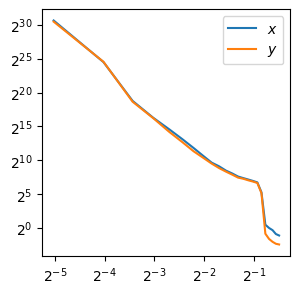

In [14]:
x_ps, x_edges = isotropic_power_spectrum(x[1, cfg.trajectory.length - 1], spatial=2)
y_ps, _ = isotropic_power_spectrum(x_hat[1, cfg.trajectory.length - 1], spatial=2)

plt.figure(figsize=(3.2, 3.2))
plt.loglog(x_edges[1:], x_ps, label="$x$", base=2)
plt.loglog(x_edges[1:], y_ps, label="$y$", base=2)
plt.legend()
plt.show()

## Rollout

In [15]:
mask = torch.zeros(shape, dtype=bool, device=device)
mask[:, 0] = True

y = z[:, 0]

trajectory = []

while len(trajectory) < rollout_length:
    x_hat, z_hat = infer(mask, y)

    if trajectory:
        trajectory.extend(x_hat[:, 1:].unbind(dim=1))
    else:
        trajectory.extend(x_hat.unbind(dim=1))

    y = z_hat[:, -1]

x_hat = torch.stack(trajectory, dim=1)

In [16]:
x, x_hat = x.cpu(), x_hat.cpu()

animation = animate_fields(x, x_hat, fields=cfg.dataset.fields)
display(animation)
plt.close()

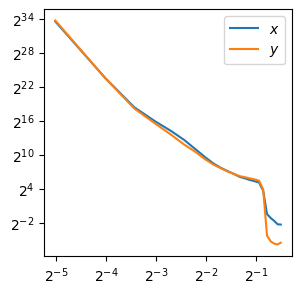

In [17]:
x_ps, x_edges = isotropic_power_spectrum(x[1, -1], spatial=2)
y_ps, _ = isotropic_power_spectrum(x_hat[1, -1], spatial=2)

plt.figure(figsize=(3.2, 3.2))
plt.loglog(x_edges[1:], x_ps, label="$x$", base=2)
plt.loglog(x_edges[1:], y_ps, label="$y$", base=2)
plt.legend()
plt.show()